In [40]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dispatches.case_studies.renewables_case.double_loop_utils import double_loop_outputs_for_gen, prescient_outputs_for_gen, read_prescient_file
from dispatches_sample_data import rts_gmlc

sns.set_style("ticks")
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=22)  # fontsize of the figure title
plt.rc('axes', titlesize=20)  # fontsize of the figure title

def calc_rev(res):
    res["Revenue"] = (res["Dispatch DA"] * res["LMP DA"] + (res["Dispatch"] - res["Dispatch DA"]) * res["LMP"]).values
    res["Revenue DA"] = (res["Dispatch DA"] * res["LMP DA"]).values
    return res

# Analysis of Wind + PEM System for Fixed Size

- 847 MW wind
- 127.05 MW pem
- 15 $/MWh
- 0.15 reservers
- 1000 shortfall price

## Prescient Sweep Results

In [53]:
double_loop_dir = "/projects/gmihybridsys/dguittet/dispatches/double_loop_parametrized_results"
dl_df = double_loop_outputs_for_gen(double_loop_dir, rts_gmlc.source_data_path)
res = dl_df[dl_df['Model'] == "Prescient"]
res = res.dropna(axis=1)
res = calc_rev(res)

# old original sweep dir
sweep_dir = "/projects/gmihybridsys/bknueven/software/dispatches/dispatches/prescient_sweeps/renewables_case_Wind_H2/results_parameter_sweep_15_1000/sweep_results_index_0.csv"
sw_df = pd.read_csv(sweep_dir)
sw_df = calc_rev(sw_df)
sw_df.Datetime = pd.to_datetime(sw_df.Datetime)
sw_df = sw_df[sw_df.Datetime.isin(dl_df.index.unique())]
sw_df.index = dl_df.index.unique()
cols = [c for c in sw_df.columns if c in res.columns]

# get total costs
sweep_dir = "/projects/gmihybridsys/bknueven/software/dispatches/dispatches/prescient_sweeps/renewables_case_Wind_H2/parameter_sweep_10_1000_index_0/hourly_summary.csv"
sw_df['TotalCosts'] = pd.read_csv(sweep_dir).TotalCosts.values[:len(sw_df)]
sw_df.describe()

,Dispatch,LMP,Dispatch DA,LMP DA,Revenue,Revenue DA,TotalCosts
count,8737.000000,8737.000000,8737.000000,8737.000000,8737.000000,8737.000000,8737.000000
mean,145.249926,30.934257,151.241093,19.718406,-865.900432,2236.338801,59571.129380
std,182.726042,99.810219,186.146251,20.337040,28366.024209,4418.995238,32350.958070
min,0.000000,-0.077733,0.000000,-0.000000,-692108.190000,-0.000000,14894.769035
25%,6.000000,0.000000,0.700000,0.000000,0.000000,0.000000,33513.920914
50%,41.300000,19.689430,53.200000,20.400003,275.370877,202.937459,54448.580296
75%,257.300000,22.968160,271.200000,24.617414,2334.725277,2826.079127,76752.358697
max,654.600000,1259.668400,712.550000,131.250711,151136.798000,55808.088917,245232.033724


In [20]:
# verbose sweep dir
sweep_week_dir = "/projects/gmihybridsys/bknueven/software/dispatches/parameter_sweep_15_1000_july_index_0"
sweep_week_dir = "/projects/gmihybridsys/bknueven/software/dispatches/parameter_sweep_15_1000_index_0"
sww_df = prescient_outputs_for_gen(sweep_week_dir, rts_gmlc.source_data_path, '303_WIND_1')
sww_pem_df = read_prescient_file(sweep_week_dir + '/renewables_detail.csv').query("Generator == '303_WIND_1_PEM'")
sww_df = sww_df.rename(columns={
    "Output": "Dispatch", "Output DA": "Dispatch DA"
})
sww_df['Dispatch'] += sww_pem_df['Output']
sww_df['Dispatch DA'] += sww_pem_df['Output DA']
sww_df = calc_rev(sww_df)
sww_df[cols].describe()

,Dispatch,LMP,Dispatch DA,LMP DA,Revenue,Revenue DA
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,236.715109,8.457893,212.126262,11.808150,2201.284075,2309.720594
std,220.274191,21.355145,207.872931,20.581767,5204.002140,5052.686439
min,0.000000,-0.000000,0.000000,-0.000000,-6364.729595,-0.000000
25%,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000
50%,188.100000,-0.000000,150.956321,-0.000000,-0.000000,-0.000000
75%,457.284574,15.000000,434.350431,19.133655,1739.236615,2117.672821
max,606.470729,127.050889,596.595910,94.066686,30071.248736,31032.599711


### Double Loop Results

from `run_double_loop_PEM.py`

In [46]:
sw_df.columns

Index(['Datetime', 'Dispatch', 'LMP', 'Dispatch DA', 'LMP DA', 'Revenue',
       'Revenue DA'],
      dtype='object')

In [72]:
# Comparing double loop revenue for smallest PEM size and bid (index 0)
import numpy as np
rev_dl_index0 = res['Revenue']
rev_sw_index0 = sw_df['Revenue']
tc_dl_index0 = res['TotalCosts']
tc_sw_index0 = sw_df['TotalCosts']
print("Revenue", rev_dl_index0.sum(), rev_sw_index0.sum(), (rev_dl_index0.sum() - rev_sw_index0.sum())/rev_sw_index0.sum())
print("TotalCosts", tc_dl_index0.sum(), tc_sw_index0.sum(), (tc_dl_index0.sum() - tc_sw_index0.sum())/tc_sw_index0.sum())
print()
for timestep in ["1H", "1D", '7D', '1M', '12M']:
    rev_dl_index0 = res.resample(timestep).mean()['Revenue']
    rev_sw_index0 = sw_df.resample(timestep).mean()['Revenue']
    tc_dl_index0 = res.resample(timestep).mean()['TotalCosts']
    tc_sw_index0 = sw_df.resample(timestep).mean()['TotalCosts']
    print(timestep, np.linalg.norm(rev_dl_index0 - rev_sw_index0, np.inf), np.linalg.norm(rev_dl_index0 - rev_sw_index0, 2))
    # np.linalg.norm((rev_index0 - sw_index0)/sw_index0, np.inf), np.linalg.norm((rev_index0 - sw_index0)/sw_index0, 2)


Revenue -7544097.750642087 -7565372.070212638 -0.002812065206193189
TotalCosts 534751182.069093 520472957.3926999 0.02743317298927423

1H 589630.8916549692 1447066.333024206
1D 38985.07669792058 81963.51078372609
7D 4713.155166234676 11529.222118593387
1M 1834.9758340194567 2745.4558191270453
12M 1167.249063700444 1172.0510870420162


### Plot Differences

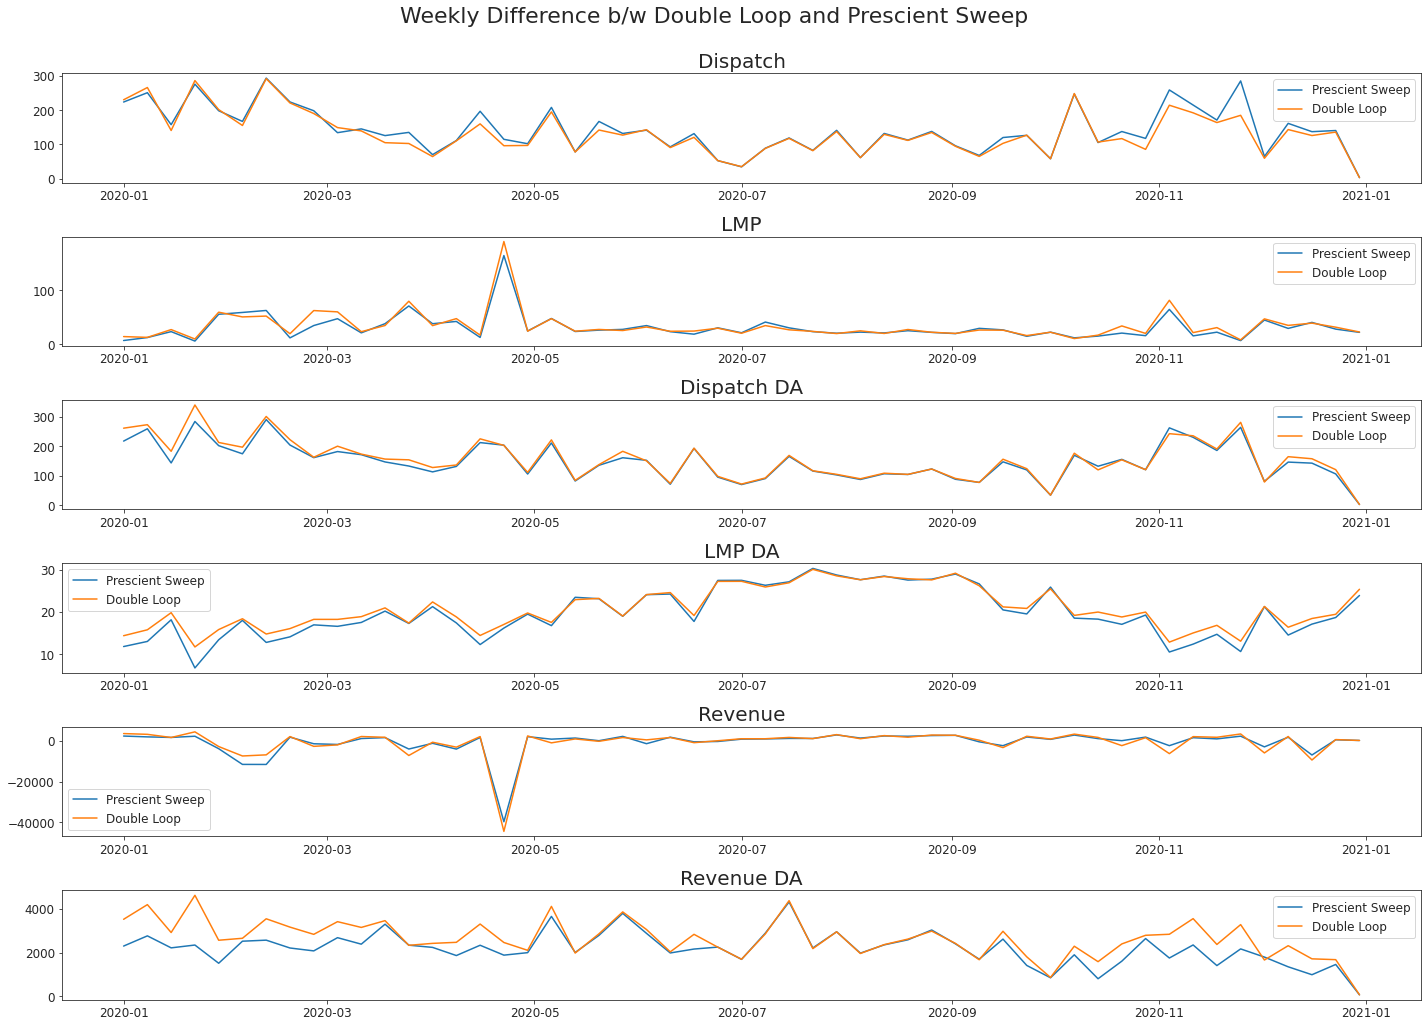

In [7]:
res_month = res.resample("7D").mean()
sw_df_month = sw_df.resample("7D").mean()

# Monthly Difference between annual Prescient sweep and double loop
fig, ax = plt.subplots(len(cols), 1, figsize=(20, 2.5 * len(cols)))
for i, c in enumerate(cols):
    ax[i].plot(sw_df_month[c], label="Prescient Sweep")
    ax[i].plot(res_month[c], label="Double Loop")
    ax[i].set_title(c)
    ax[i].legend()
plt.suptitle("Weekly Difference b/w Double Loop and Prescient Sweep")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

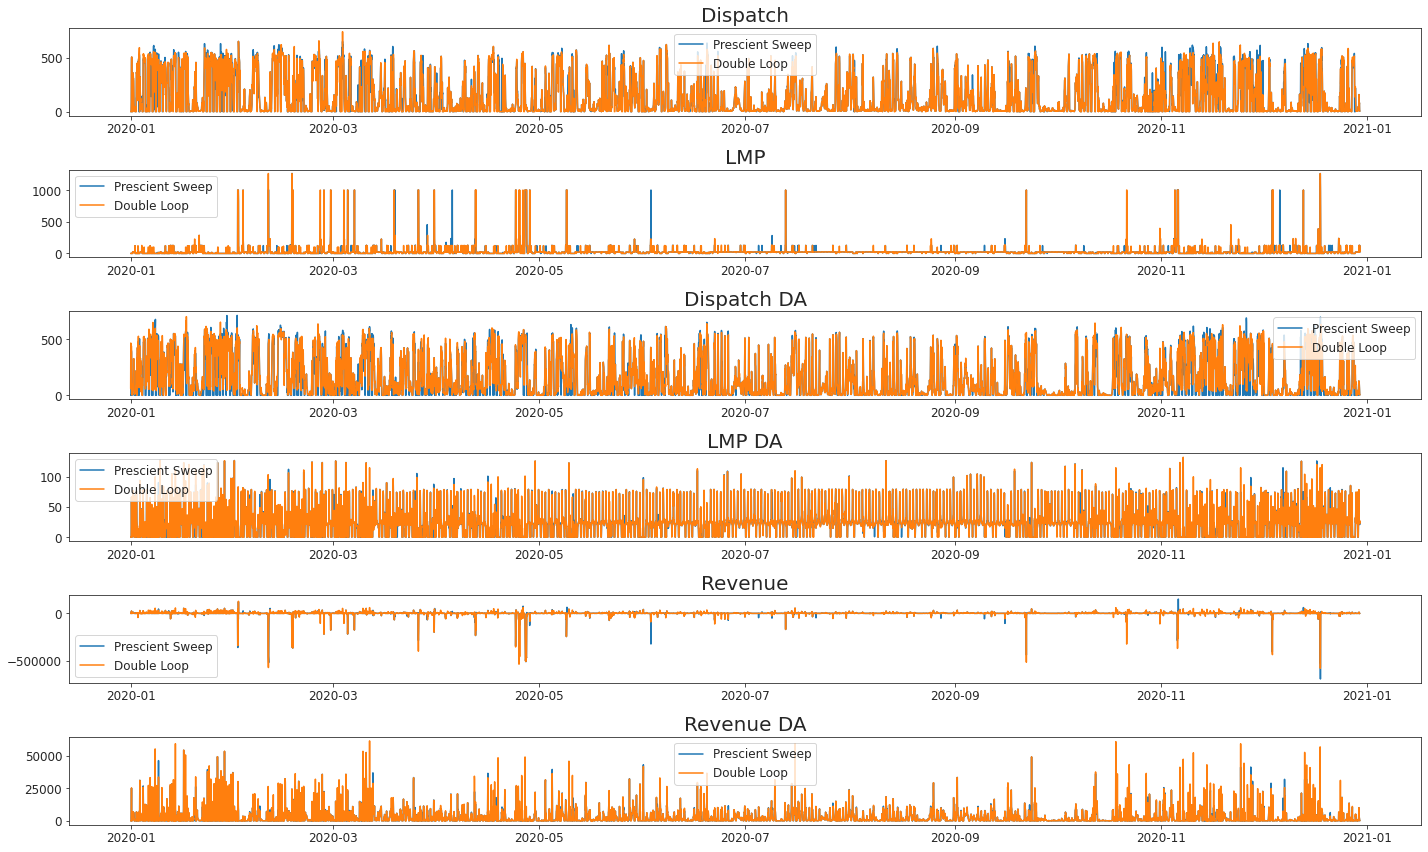

In [8]:
# Difference between annual Prescient sweep and double loop
fig, ax = plt.subplots(len(cols), 1, figsize=(20, 2 * len(cols)))
for i, c in enumerate(cols):
    ax[i].plot(sw_df[c], label="Prescient Sweep")
    ax[i].plot(res[c], label="Double Loop")
    ax[i].set_title(c)
    ax[i].legend()
fig.tight_layout()

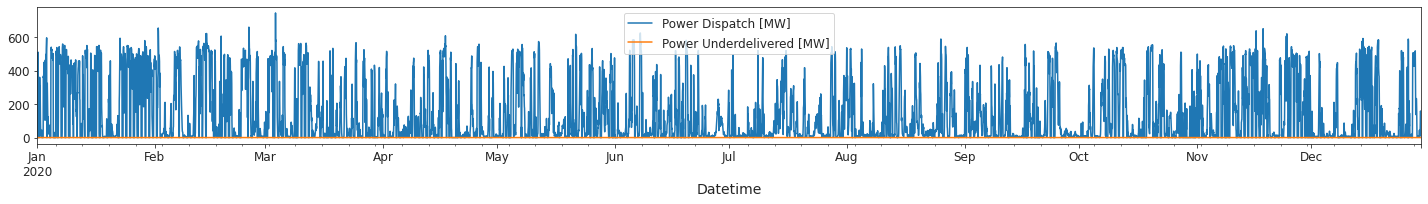

In [42]:
tracker_df = dl_df[dl_df['Model'] == 'Tracker'].dropna(axis=1)

fig, ax = plt.subplots(1, 1, figsize=(20, 3))
tracker_df[tracker_df['Horizon [hr]'] == 0][["Power Dispatch [MW]", "Power Underdelivered [MW]"]].plot(ax=ax)
plt.tight_layout()

## Compare Optimal Size Revenue

### Surrogate Conceptual Design
Wind capacity = 847.0 MW

PEM capacity = 247.70 MW

Plant bid = $29.71

Plant Elec Revenue Annual = $24,927.10

Plant Hydrogen Revenue Annual = $51,748,756.74

Plant Total Revenue Annual = $51,773,684.04

Plant NPV = $-1,252,263,849.68

### Pricetaker Conceptual Design w/ DA
Wind capacity = 847.0 MW

PEM capacity = 247.70 MW

Plant Elec Revenue Annual = $24927.10

Plant Hydrogen Revenue Annual = $114,535,880.57

Plant Total Revenue Annual = $-36733437.67

Plant NPV = $-1252263849.68

In [69]:
double_loop_dir = "/projects/gmihybridsys/dguittet/dispatches/double_loop_parametrized_results_opt"
res_opt = prescient_outputs_for_gen(double_loop_dir, rts_gmlc.source_data_path, "303_WIND_1")
res_opt = res_opt.dropna(axis=1)
res_opt = calc_rev(res_opt)
# calculate hydrogen revenue from excess wind
res_opt['ExcessWind'] = res_opt['303_WIND_1-RTCF'] * 847 - res_opt['Dispatch']
res_opt['PEM'] = res_opt['ExcessWind'].clip(lower=0, upper=247.7)
res_opt['HydrogenRevenue'] = res_opt['PEM'] / 54.953 * 3 * 1e3

# closest sweep run
sweep_opt_dir = "/projects/gmihybridsys/bknueven/software/dispatches/dispatches/prescient_sweeps/renewables_case_Wind_H2/results_parameter_sweep_15_1000/sweep_results_index_24.csv"
sw_opt = pd.read_csv(sweep_opt_dir)
sw_opt = calc_rev(sw_opt)
sw_opt.Datetime = pd.to_datetime(sw_opt.Datetime)
sw_opt = sw_opt[sw_opt.Datetime.isin(res_opt.index.unique())]
sw_opt.index = res_opt.index.unique()
# cols = [c for c in sw_df.columns if c in res.columns]

# get total costs
sweep_dir = "/projects/gmihybridsys/bknueven/software/dispatches/dispatches/prescient_sweeps/renewables_case_Wind_H2/parameter_sweep_10_1000_index_24/hourly_summary.csv"
sw_opt['TotalCosts'] = pd.read_csv(sweep_dir).TotalCosts.values[:len(sw_opt)]
sw_opt.describe()

,Dispatch,LMP,Dispatch DA,LMP DA,Revenue,Revenue DA,TotalCosts
count,8780.000000,8780.000000,8780.000000,8780.000000,8780.000000,8780.000000,8780.000000
mean,90.348664,30.021794,91.582087,20.879611,-359.282982,1460.767952,60555.909889
std,163.329227,94.912135,161.429012,19.640336,24822.021397,3959.728803,32420.279955
min,0.000000,-0.000000,0.000000,-0.000000,-594278.118261,-0.000000,14165.383433
25%,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,34592.568556
50%,0.000000,20.419098,0.000000,21.288154,0.000000,0.000000,55616.092379
75%,101.222300,23.128644,115.002678,25.953694,337.636864,0.000000,78202.286814
max,663.947476,1785.261656,619.203757,127.274563,183500.000000,52232.162709,245232.033724


In [85]:
h2_rev_opt = 51748756
elec_rev_opt = 24927
tot_rev_opt = h2_rev_opt + elec_rev_opt

# Comparing double loop revenue to closest sweep run
rev_dl_opt = res_opt['Revenue'].sum()
rev_h2_dl_opt = res_opt['HydrogenRevenue'].sum()
rev_tot_dl_opt = rev_dl_opt + rev_h2_dl_opt
tc_dl_opt = res_opt['TotalCosts'].sum()

rev_sw_opt = sw_opt['Revenue'].sum()
tc_sw_opt = sw_opt['TotalCosts'].sum()
print("Revenue", rev_dl_opt, rev_sw_opt, (rev_dl_opt - rev_sw_opt)/rev_sw_opt)
print("TotalCosts", tc_dl_opt, tc_sw_opt, (tc_dl_opt - tc_sw_opt)/tc_sw_opt)

# Comparing double loop revenue with conceptual design revenue
print("Elec Revenue", rev_dl_opt, elec_rev_opt, (rev_dl_opt - elec_rev_opt) / elec_rev_opt)
print("H2 Revenue", rev_h2_dl_opt, h2_rev_opt, (rev_h2_dl_opt - h2_rev_opt) / h2_rev_opt)
print("Total Revenue", rev_tot_dl_opt, tot_rev_opt, (rev_tot_dl_opt - tot_rev_opt) / tot_rev_opt)

Revenue -3855525.380483118 -3154504.578831599 0.2222284939307873
TotalCosts 542739148.594453 531680888.8265909 0.020798678305453934
Elec Revenue -3855525.380483118 24927 -155.67265938472812
H2 Revenue 57523499.71874146 51748756 0.1115919331228264
Total Revenue 53667974.33825834 51773683 0.03658791935389918
